In [1]:
!pip install -q qiskit
!pip install -q qiskit-aer
!pip install -q pylatexenc
!pip install -q qiskit_ibm_runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 31.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 105.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.9/363.9 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 9.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that 

In [16]:
from qiskit.circuit import Parameter
from qiskit_aer import AerSimulator
from qiskit import QuantumCircuit, transpile
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_aer.noise import NoiseModel

In [27]:
backend= AerSimulator()

#defining the parameters
J= 1.0  #coupling constant is assumed to be 1 in the model.
t= Parameter("t")
parametric_values= np.linspace(0, np.pi/2, 30)

#initialising the circuit
qc= QuantumCircuit(2)
qc.x(0)  #changing the initial state to |01>
qc.rxx(2*J*t, 0, 1)
qc.ryy(2*J*t, 0, 1)
qc.rzz(2*J*t, 0, 1)
qc.measure_all()
qc = transpile(qc, backend)

#initial expectations at t = 0
E0_initial= -1  #since the 0th qubit in the initial state |01> is 1 so the expectation of Z is down.
E1_initial= +1

E0 = []
E1 = []
E_prod = []
corr_01 = []
ideal = []
corr_10 = []

for val in parametric_values:
    bound_circuit= qc.assign_parameters({t: val})
    result= backend.run(bound_circuit, shots=1024).result()
    counts= result.get_counts()
    probabilities= [[x, y/1024] for x, y in counts.items()]
    ideal.append(probabilities)

    #calculating the expectation values
    e_0, e_1, e_prod = 0, 0, 0
    for state, p in probabilities:
        spin_0 = 1- (2*int(state[1])) #spin_0 becomes -1 if the 0th qubit(state[1]) is 1 and 1 if its 0.
        spin_1 = 1- (2*int(state[0]))
        e_0 += p*spin_0 #expectaiton value of spin is calculated by summing the product of probability and the spin
        e_1 += p*spin_1
        e_prod += p*spin_0*spin_1

    C_01= e_prod - e_0*E1_initial
    C_10= e_prod - e_1*E0_initial


    E0.append(e_0)
    E1.append(e_1)
    E_prod.append(e_prod)
    corr_01.append(C_01)
    corr_10.append(C_10)

/tmp/ipython-input-28-1887319592.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipython-input-28-1887319592.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipython-input-28-1887319592.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


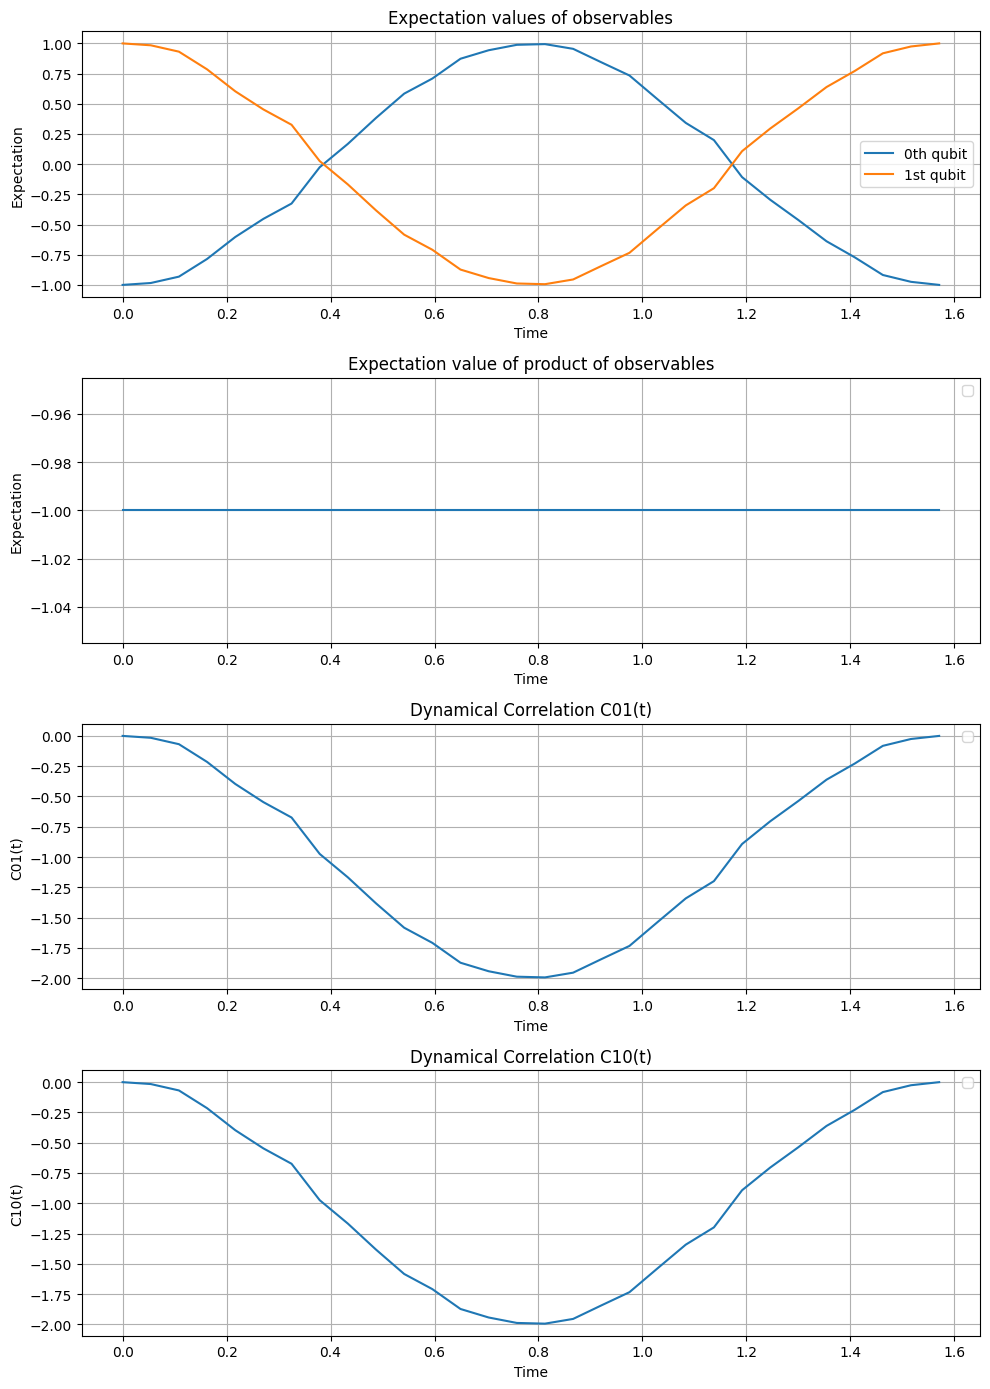

In [28]:
#plotting the expectation values and the dynamical correlations

plt.figure(figsize=(10, 14))

plt.subplot(4, 1, 1)
plt.plot(parametric_values, E0, label = "0th qubit")
plt.plot(parametric_values, E1, label="1st qubit")
plt.title("Expectation values of observables")
plt.xlabel("Time")
plt.ylabel("Expectation")
plt.legend()
plt.grid(True)

#expecation values of product (this is always -1 since the product of z upon measuring is always -1)
plt.subplot(4, 1, 2)
plt.plot(parametric_values, E_prod)
plt.title("Expectation value of product of observables")
plt.xlabel("Time")
plt.ylabel("Expectation")
plt.legend()
plt.grid(True)

#dynamical correlation C01(t)
plt.subplot(4, 1, 3)
plt.plot(parametric_values, corr_01)
plt.title("Dynamical Correlation C01(t)")
plt.xlabel("Time")
plt.ylabel("C01(t)")
plt.legend()
plt.grid(True)

#dynamical correlation C10(t)
plt.subplot(4, 1, 4)
plt.plot(parametric_values, corr_10)
plt.title("Dynamical Correlation C10(t)")
plt.xlabel("Time")
plt.ylabel("C10(t)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [29]:
#adding noise in the simulations
fake_backend = FakeSherbrooke()
noise_model = NoiseModel.from_backend(fake_backend)
noisy_backend = AerSimulator(noise_model=noise_model)
noise_circuit = transpile(qc, noisy_backend)

distribution_noise = []

for i in parametric_values:
    bound = noise_circuit.assign_parameters({t: i})
    result = noisy_backend.run(bound, shots=1024).result()
    counts = result.get_counts()
    probabilties = [[x, y/1024] for x, y in counts.items()]
    distribution_noise.append(probabilities)


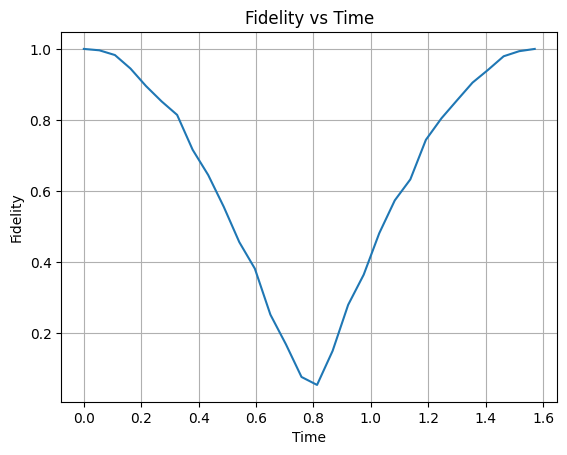

In [32]:
fidelity_values = []

for i in range(len(parametric_values)):
    ideal_list= ideal[i]
    noisy_list= distribution_noise[i]


    all_states= set([x[0] for x in ideal_list] + [x[0] for x in noisy_list])
    fidelity= 0

    for state in all_states:
        p_ideal= 0
        for s, p in ideal_list:
            if s== state:
                p_ideal= p
                break

        p_noisy = 0
        for s, p in noisy_list:
            if s== state:
                p_noisy= p
                break
        fidelity+= np.sqrt(p_ideal*p_noisy)

    fidelity_values.append(fidelity)

#plotting fidelity vs time
plt.plot(parametric_values, fidelity_values)
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity vs Time")
plt.grid(True)
plt.show()